# Time Series Forecasting w/ Facebook's Prophet

Adopted from https://facebook.github.io/prophet/docs/quick_start.html. 

Other good resources include: 
https://xang1234.github.io/prophet/.

By default, Prophet uses an additive model

\begin{align}
y(t) = g(t) + s(t) + h(t) + \epsilon_t \\
\end{align}

where 
g(t) represents the trend, s(t) the periodic (i.e. seasonal) component, 
h(t) holiday related events and ϵ_t the error. 
The periodic component can be broken into monthly seasonality and weekly seasonality components.
The model can also be switched to use 

In [35]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import git
repo = git.Repo("./", search_parent_directories=True)
homedir = repo.working_dir

In [58]:
# Facebook's Open Source Time Series Analysis Tool
# pip install pystan
# pip install fbprophet
# If above ^ command doesn't install, see below issue
# https://github.com/facebook/prophet/issues/775
# pip install fbprophet --no-cache-dir --no-binary :all:
# Also for interactive visualizations you can install Plotly
# pip install plotly
import datetime
from fbprophet import Prophet
from fbprophet.plot import add_changepoints_to_plot
from fbprophet.diagnostics import cross_validation
from fbprophet.diagnostics import performance_metrics
from fbprophet.plot import plot_cross_validation_metric

In [37]:
df = pd.read_csv(f"{homedir}/data/us/flu/cases/ILI_Ages.csv")

In [38]:
df.head()

,REGION TYPE,REGION,YEAR,WEEK,% WEIGHTED ILI,%UNWEIGHTED ILI,AGE 0-4,AGE 25-49,AGE 25-64,AGE 5-24,AGE 50-64,AGE 65,ILITOTAL,NUM. OF PROVIDERS,TOTAL PATIENTS
0,National,X,1997,40,1.10148,1.21686,179,X,157,205,X,29,570,192,46842
1,National,X,1997,41,1.20007,1.28064,199,X,151,242,X,23,615,191,48023
2,National,X,1997,42,1.37876,1.23906,228,X,153,266,X,34,681,219,54961
3,National,X,1997,43,1.19920,1.14473,188,X,193,236,X,36,653,213,57044
4,National,X,1997,44,1.65618,1.26112,217,X,162,280,X,41,700,213,55506


In [39]:
# Prophet requires daily data, so we will just transform from week to day
def get_first_day_of_week(yr, wk):
    d = "%s-W%s" % (yr, wk)
    # The -1 and -%w pattern tells the parser to pick the Monday in that week
    firstdayofweek = datetime.datetime.strptime(d + '-1', "%Y-W%W-%w")
    return firstdayofweek

In [40]:
# Prophet also requires dates to be stored in a column called 'ds'
# And that the values to predict will be stored in a column called 'y'
y_name = "ILITOTAL"
df["ds"] = df.apply(lambda row: get_first_day_of_week(row.YEAR, row.WEEK), axis=1)
df["y"] = df[y_name]
df.tail()

,REGION TYPE,REGION,YEAR,WEEK,% WEIGHTED ILI,%UNWEIGHTED ILI,AGE 0-4,AGE 25-49,AGE 25-64,AGE 5-24,AGE 50-64,AGE 65,ILITOTAL,NUM. OF PROVIDERS,TOTAL PATIENTS,ds,y
1167,National,X,2020,7,5.99056,6.18745,17176,26193,X,36531,9179,5397,94476,2946,1526897,2020-02-17,94476
1168,National,X,2020,8,5.39490,5.60028,15122,22944,X,28164,8280,5116,79626,2950,1421823,2020-02-24,79626
1169,National,X,2020,9,5.08334,5.10641,13514,21767,X,24935,8147,5006,73369,2881,1436802,2020-03-02,73369
1170,National,X,2020,10,5.17801,5.28829,13380,23434,X,25452,8728,5561,76555,2794,1447633,2020-03-09,76555
1171,National,X,2020,11,5.82936,6.51981,13236,28704,X,25981,10933,6430,85284,2497,1308074,2020-03-16,85284


In [47]:
# Possible setting changes
# changepoint_prior_scale=0.5 (1 default)
# seasonality_mode='multiplicative' ('additive' default)
# Adding separate regressors to the model
m = Prophet()
m.fit(df)

INFO:fbprophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


In [48]:
future = m.make_future_dataframe(periods=90)
future.tail()

,ds
1257,2020-06-10
1258,2020-06-11
1259,2020-06-12
1260,2020-06-13
1261,2020-06-14


In [51]:
forecast = m.predict(future)

,ds,trend,yhat_lower,yhat_upper,trend_lower,trend_upper,additive_terms,additive_terms_lower,additive_terms_upper,yearly,yearly_lower,yearly_upper,multiplicative_terms,multiplicative_terms_lower,multiplicative_terms_upper,yhat
1257,2020-06-10,37662.477521,20480.699999,42690.689796,37661.814913,37664.940304,-6057.632839,-6057.632839,-6057.632839,-6057.632839,-6057.632839,-6057.632839,0.0,0.0,0.0,31604.844682
1258,2020-06-11,37676.564368,20170.181579,41649.576305,37675.720091,37679.259160,-6139.844646,-6139.844646,-6139.844646,-6139.844646,-6139.844646,-6139.844646,0.0,0.0,0.0,31536.719722
1259,2020-06-12,37690.651215,19558.110727,42607.503326,37689.627115,37693.465447,-6218.081653,-6218.081653,-6218.081653,-6218.081653,-6218.081653,-6218.081653,0.0,0.0,0.0,31472.569562
1260,2020-06-13,37704.738063,21594.027445,43307.878538,37703.620758,37707.720906,-6291.960357,-6291.960357,-6291.960357,-6291.960357,-6291.960357,-6291.960357,0.0,0.0,0.0,31412.777706
1261,2020-06-14,37718.824910,20451.654453,42080.704601,37717.534636,37722.006873,-6361.215884,-6361.215884,-6361.215884,-6361.215884,-6361.215884,-6361.215884,0.0,0.0,0.0,31357.609026


In [52]:
forecast.tail()

,ds,trend,yhat_lower,yhat_upper,trend_lower,trend_upper,additive_terms,additive_terms_lower,additive_terms_upper,yearly,yearly_lower,yearly_upper,multiplicative_terms,multiplicative_terms_lower,multiplicative_terms_upper,yhat
1257,2020-06-10,37662.477521,20480.699999,42690.689796,37661.814913,37664.940304,-6057.632839,-6057.632839,-6057.632839,-6057.632839,-6057.632839,-6057.632839,0.0,0.0,0.0,31604.844682
1258,2020-06-11,37676.564368,20170.181579,41649.576305,37675.720091,37679.259160,-6139.844646,-6139.844646,-6139.844646,-6139.844646,-6139.844646,-6139.844646,0.0,0.0,0.0,31536.719722
1259,2020-06-12,37690.651215,19558.110727,42607.503326,37689.627115,37693.465447,-6218.081653,-6218.081653,-6218.081653,-6218.081653,-6218.081653,-6218.081653,0.0,0.0,0.0,31472.569562
1260,2020-06-13,37704.738063,21594.027445,43307.878538,37703.620758,37707.720906,-6291.960357,-6291.960357,-6291.960357,-6291.960357,-6291.960357,-6291.960357,0.0,0.0,0.0,31412.777706
1261,2020-06-14,37718.824910,20451.654453,42080.704601,37717.534636,37722.006873,-6361.215884,-6361.215884,-6361.215884,-6361.215884,-6361.215884,-6361.215884,0.0,0.0,0.0,31357.609026


In [53]:
forecast[['ds', 'yhat', 'yhat_lower', 'yhat_upper']].tail()

,ds,yhat,yhat_lower,yhat_upper
1257,2020-06-10,31604.844682,20480.699999,42690.689796
1258,2020-06-11,31536.719722,20170.181579,41649.576305
1259,2020-06-12,31472.569562,19558.110727,42607.503326
1260,2020-06-13,31412.777706,21594.027445,43307.878538
1261,2020-06-14,31357.609026,20451.654453,42080.704601


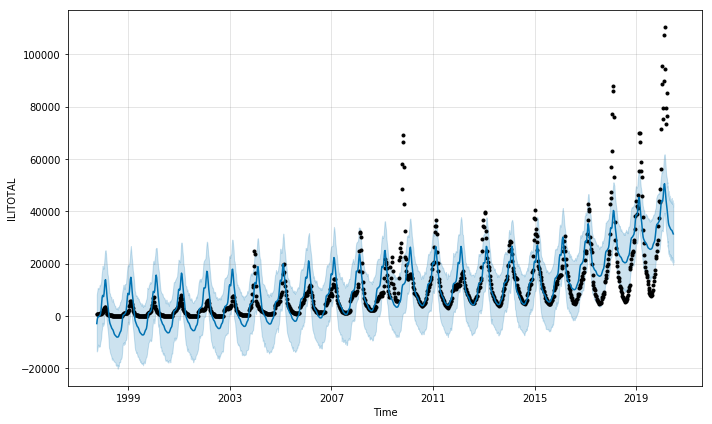

In [57]:
# Note that H1N1 outbreak and increased volumn of patients break the forecast
fig1 = m.plot(forecast, xlabel="Time", ylabel=y_name)
# Uncomment to see where the trend line changes
# a=add_changepoints_to_plot(fig1.gca(), m, forecast)

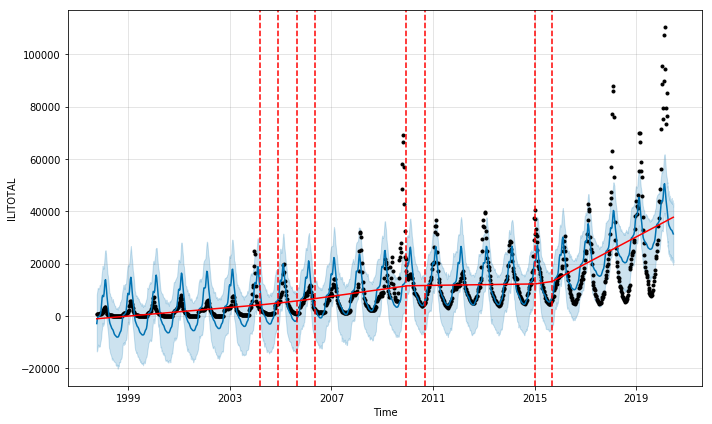

In [56]:
fig1 = m.plot(forecast, xlabel="Time", ylabel=y_name)
# Uncomment to see where the trend line changes
a=add_changepoints_to_plot(fig1.gca(), m, forecast)

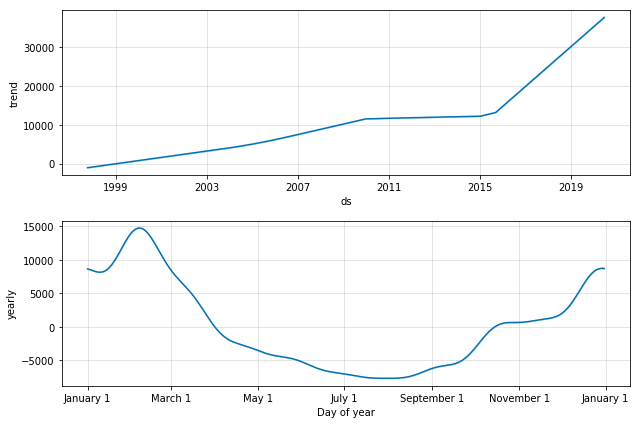

In [66]:
# Plot the yearly trends and monthly seasonality component
fig2 = m.plot_components(forecast)

In [68]:
# Cross Validation to measure forecast error
# Note: This takes a couple min (3-5)
%time df_cv = cross_validation(m, initial='4000 days', period='30 days', horizon = '365 days')

INFO:fbprophet:Making 128 forecasts with cutoffs between 2008-10-10 00:00:00 and 2019-03-17 00:00:00


CPU times: user 3min 34s, sys: 1.78 s, total: 3min 36s
Wall time: 3min 38s


In [69]:
df_p = performance_metrics(df_cv)
df_p.head()

,horizon,mse,rmse,mae,mape,mdape,coverage
0,37 days,1.130179e+08,10630.986987,6595.976981,0.505178,0.363919,0.680891
1,38 days,1.172423e+08,10827.847265,6657.805102,0.506779,0.369167,0.679680
2,39 days,1.159712e+08,10768.991545,6632.196424,0.505730,0.375517,0.681761
3,40 days,1.180127e+08,10863.366124,6703.470793,0.509999,0.375883,0.678345
4,41 days,1.178657e+08,10856.596878,6701.939402,0.509845,0.378284,0.680013
